#Movie Recommender System#
###Shreya Balaji, Tyler Headley, and Bryce Tu Chi###

*View and run this code in [Colab](https://colab.research.google.com/drive/1aNrr-wY64Mme2k1fraCMpqmlyoquIpU4?usp=sharing)*

This is our final project for MATH189: Mathematical Data Science & Topic Modeling. Our recommender system draws literature

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
# get dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/MyDrive/Math189 Project: Movie Recommendations/Datasets/MovieRecommenderSystemDataset"

# !ls "/content/drive/MyDrive/Math189 Project: Movie Recommendations/Datasets/"

Mounted at /content/drive/
Archive:  /content/drive/MyDrive/Math189 Project: Movie Recommendations/Datasets/MovieRecommenderSystemDataset.zip
  inflating: movies.csv              
  inflating: ratings.csv             


In [ ]:
# put dataset into Pandas DataFrames
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')



#Data Exploration#
Now we'll do some data exploration and visualization to get to know our dataset better. We'll start out by taking a look at the sampling distribution for the ratings given to movies in our dataset, which are values from 0.5 to 5.0.

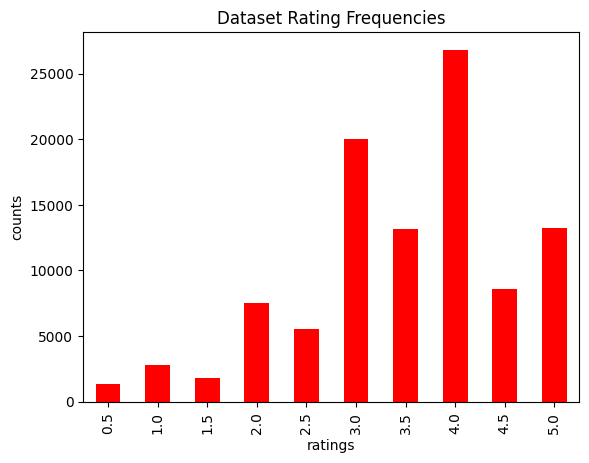

In [ ]:
# create bar plot
ratings_df['rating'].value_counts().sort_index().plot(kind="bar", color='red')

# add labels and title
plt.xlabel('ratings')
plt.ylabel('counts')
plt.title('Dataset Rating Frequencies')

plt.show()

Next, we'll dig into the movies dataset and explore what types of movies are present.

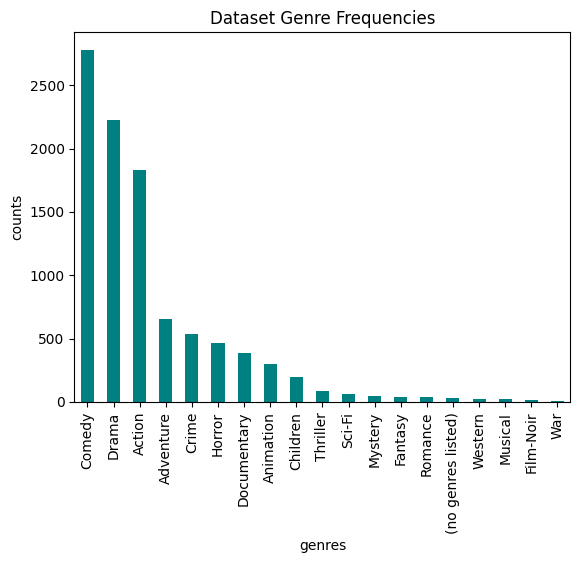

In [ ]:
# movies are tagged with multiple genres listed in one column, separated by "|"
categories = movies_df['genres'].str.split("|", expand=True) # create dataframe with a separate column for each genre
category_counts = categories[0].value_counts() # initialize category counts

for i in range(1, categories.shape[1]):
  # if new genre not already in Series, initialize it to zero
  category_counts.add(categories[i].value_counts(), fill_value=0)

# create bar plot
category_counts.plot(kind="bar", color='teal')

# add labels and title
plt.xlabel('genres')
plt.ylabel('counts')
plt.title('Dataset Genre Frequencies')

plt.show()

#Data Processing#
The next step is to prepare the data in the Pandas dataframes for NMF. This means we first need to construct a User-Item Rating Matrix which will be used in the collaborative filtering algorithm.

In [ ]:
# function to convert dataframes into numpy data matrix for NMF
def dataframesToMatrix(movies_df, ratings_df):

  # create matrix with dimensions |Users| X |Movies|
  matrix = np.zeros((ratings_df.loc[ratings_df.shape[0] - 1, 'userId'], movies_df.shape[0]))
  I_U = np.zeros(matrix.shape[0])
  U_I = np.zeros(matrix.shape[1])

  # for each rating given to a movie by a user, set the entry at the corresponding location in the matrix to that rating
  # otherwise, the entry will remain zero (might change that later?)
  for index, row in ratings_df.iterrows():
    userIndex = int(row['userId']) - 1 # 610 users, each with unique IDs from 1 to 610 (no gaps)
    movieIndex = movies_df.index[movies_df['movieId'] == row['movieId']].tolist()[0] # 9742 movies with unique IDs from 1 to 193609 (some gaps between IDs)

    matrix[userIndex][movieIndex] = row['rating'] # place rating value at corresponding index in matrix
    I_U[userIndex] += 1
    U_I[movieIndex] += 1

  return matrix, I_U, U_I




In [ ]:
R, I_U, U_I = dataframesToMatrix(movies_df, ratings_df)
R.shape # |U| x |I|
print(I_U)
print(U_I)


[ 232.   29.   39.  216.   44.  314.  152.   47.   46.  140.   64.   32.
   31.   48.  135.   98.  105.  502.  703.  242.  443.  119.  121.  110.
   26.   21.  135.  570.   81.   34.   50.  102.  156.   86.   23.   60.
   21.   78.  100.  103.  217.  440.  114.   48.  399.   42.  140.   33.
   21.  310.  359.  130.   20.   33.   25.   46.  476.  112.  107.   22.
   39.  366.  271.  517.   34.  345.   36. 1260.   46.   62.   35.   45.
  210.  177.   69.  119.   29.   61.   64.  167.   26.  227.  118.  293.
   34.   70.   21.   56.  518.   54.  575.   24.   97.   56.  168.   78.
   36.   92.   53.  148.   61.   56.  377.  273.  722.   33.   34.   76.
  127.   51.  646.   65.  150.   31.  112.   87.  165.   22.  215.   22.
   58.  292.   56.   50.  360.   38.   22.   33.  140.   28.   69.  347.
   35.   35.  279.  111.  141.   22.  194.  608.  168.   38.   71.  128.
   23.   32.   20.   48.   58.   26.   59.   63.  179.   34.   46.  398.
   21.   26.   97.  437.   39.   38.   23.   36.   

Sparsity = # non-zero entries / # total entries = $\frac{100836}{610 * 9742}$ = 0.01696827325

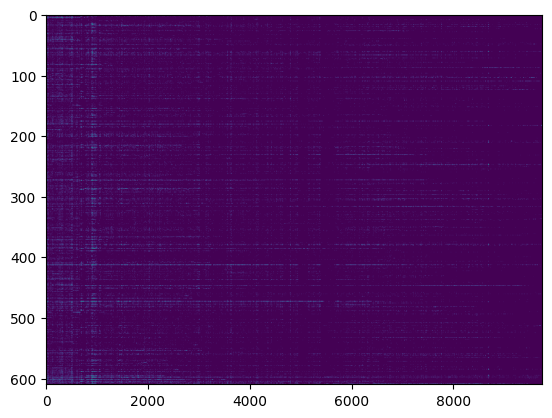

In [ ]:
# display values of matrix entries by index
plt.imshow(A, aspect='auto')
plt.show()

We can see the extreme sparsity of our user-item data matrix, which will mandate use of a specialized form of NMF for Collaborative Filtering so that we can fill in missing values.

In [ ]:
def mult_ups(X, k, M = 10):
  eps_divide = 1e-6                                                 #define a small number to ensure we never divide by 0
  m,N = np.shape(X)                                                 #determine the size of X for initializing A and S

  if M < 1:
    raise Exception("Not a valid number of iterations.")            #error if number of iterations is less than 1

  A = np.abs(np.random.randn(m,k))                                  #initialize factor matrices
  S = np.abs(np.random.randn(k,N))

  errors = [np.linalg.norm(X-A@S,'fro')**2]                          #initialize error array

  for i in range(M):
    A = A*((X@np.transpose(S))/(A@S@np.transpose(S) + eps_divide))  #update for A
    S = S*((np.transpose(A)@X)/(np.transpose(A)@A@S + eps_divide))  #update for S

    errors.append(np.linalg.norm(X-A@S,'fro')**2)                    #record error

  return A, S, errors

P, Q, errors = mult_ups(A, 10, M = 150)

print(P)
print(Q)
print(errors)

[[4.32436024e-10 7.82805751e-02 1.08158787e-14 ... 1.26080950e-39
  1.72807150e-02 5.85634302e-03]
 [8.99347646e-38 1.39035129e-90 1.20181249e-72 ... 1.08278927e-02
  9.83375208e-03 1.48457341e-24]
 [1.00115142e-82 4.19829464e-03 2.29758059e-50 ... 1.98605914e-58
  9.13221211e-93 2.53465652e-66]
 ...
 [6.24914062e-02 1.01349626e-01 1.13505453e-10 ... 9.62626477e-16
  3.13795034e-02 1.09487401e-02]
 [1.06157485e-45 5.36140073e-28 5.40577727e-35 ... 9.50172188e-23
  3.14607000e-03 3.19642479e-02]
 [1.52531384e-06 2.08211346e-02 1.09115263e-12 ... 2.06903867e-01
  6.55705384e-09 9.32020850e-10]]
[[2.08664930e+01 1.53885426e+01 4.78863334e+00 ... 0.00000000e+00
  0.00000000e+00 5.84906676e-05]
 [1.77272395e+01 1.38370206e+01 5.43752761e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.14120869e+00 3.20789815e+00 6.45883204e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.88241975e+00 1.04752981e+01 1.11995427e-81 ... 3.61664597e-01
  3.61664597e-01 3.88495591e-01]

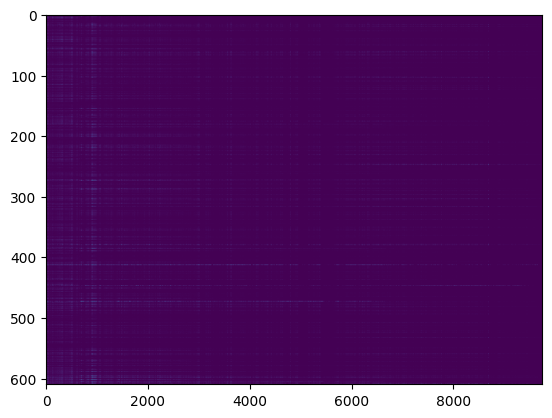

In [ ]:
X_hat = P@Q



In [ ]:
# f is the feature matrix dimension
def nmf_cf(R: np.ndarray, f: int, I_U, U_I):
  P = np.random.rand(R.shape[0], f)
  Q = np.random.rand(f, R.shape[1])

  lambda_P = .06
  lambda_Q = .06

  UserUP = np.zeros((R.shape[0], f))
  UserDOWN = np.zeros((R.shape[0], f))
  ItemUP = np.zeros((f, R.shape[1]))
  ItemDOWN = np.zeros((f, R.shape[1]))

  training_round = 0
  max_training_round = 100

  I_dim = len(R.shape[1])


  # while not converge ???
  while training_round != max_training_round:
    UserUP.fill(0)
    UserDOWN.fill(0)
    ItemUP.fill(0)
    ItemDOWN.fill(0)

    R_hat = P@Q
    for u in range(R.shape[0]):
      for i in range(R.shape[1]):
        for k in range(f):
          UserUP[u][k] = UserUP[u][k] + Q[k][i] * R[u][i]
          UserDOWN[u][k] = UserDOWN[u][k] + Q[k][i] * R_hat[u][i]
          ItemUP[k][i] = ItemUP[k][i] + P[u][k] * R[u][i]
          ItemDOWN[k][i] = ItemDOWN[k][i] + P[u][k] * R_hat[u][i]

    for u in range(R.shape[0]):
      for k in range(f):
        UserDOWN[u][k] = UserDOWN[u][k] + I_U[u] * lambda_P * P[u][k]



    UserUP = R @ np.transpose(Q)
    UserDOWN = I_dim * lambda_P + P @ Q @ np.transpose(Q)




    for u in range(R.shape[0]):
      for i in range(R.shape[1]):
        r_hat = np.dot(P[u:, ], Q[ :, i])

    print(training_round, end=" ")
    training_round += 1

  return

nmf_cf(A, 20)

KeyboardInterrupt: ignored